TELECOM CUSTOMER CHURN

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

Task 1: Load and Inspect the data

We begin by loading the 'telecom_churn.csv' dataset to understand its structure.  
The goal is to identify the data types of each column, the target variable (Churn), and any potential issues such as missing values.

In [10]:
df = pd.read_csv('/Users/subratotapaswi/Documents/ML/Lab05-Pronnati-202518052/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [12]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Handling Total Charges (Converting from object to numeric)


Issue with TotalCharges
This column was initially loaded as an **"object"** type, even though it should be numeric.  
On investigation, this happened because of non-numeric entries (blank spaces).  

We converted TotalCharges to numeric using pd.to_numeric(errors="coerce").  
This introduced **11 missing values**, which we identified after conversion.  

**Handling Missing Data:**  
The dataset originally had **0 nulls** in TotalCharges. After conversion, the 11 invalid entries became NaN.  
We calculated missing values across the dataset and found that these 11 entries represent only a very small fraction of the dataset (15%).

In [13]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [14]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Extent of Missing Values

In [15]:
missing_vals_counts = df.isna().sum()
missing_percent = (missing_vals_counts/len(df))*100
print(missing_percent)

customerID          0.000000
gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
tenure              0.000000
PhoneService        0.000000
MultipleLines       0.000000
InternetService     0.000000
OnlineSecurity      0.000000
OnlineBackup        0.000000
DeviceProtection    0.000000
TechSupport         0.000000
StreamingTV         0.000000
StreamingMovies     0.000000
Contract            0.000000
PaperlessBilling    0.000000
PaymentMethod       0.000000
MonthlyCharges      0.000000
TotalCharges        0.156183
Churn               0.000000
dtype: float64


Data Visualisation (EDA)

Distribution plot: MonthlyCharges

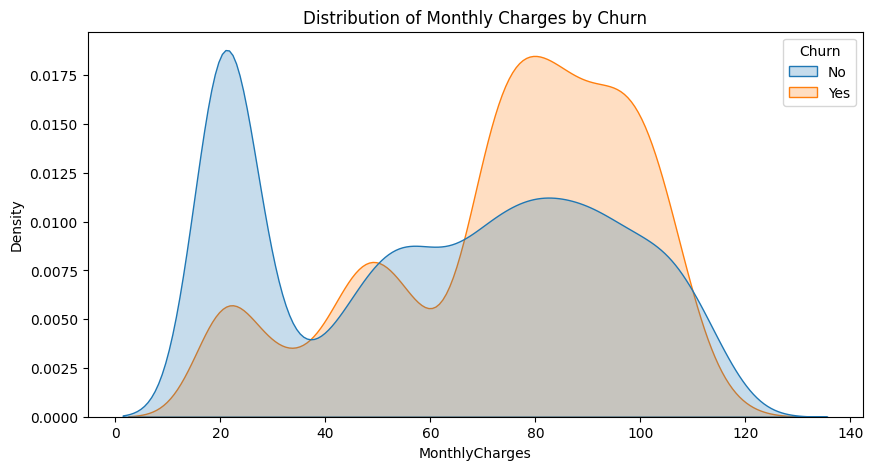

In [17]:
plt.figure(figsize=(10,5))
sns.kdeplot(data=df, x='MonthlyCharges', hue = 'Churn', fill = True, common_norm = False)
plt.title('Distribution of Monthly Charges by Churn')
plt.show()

Count plot: Contract vs Churn

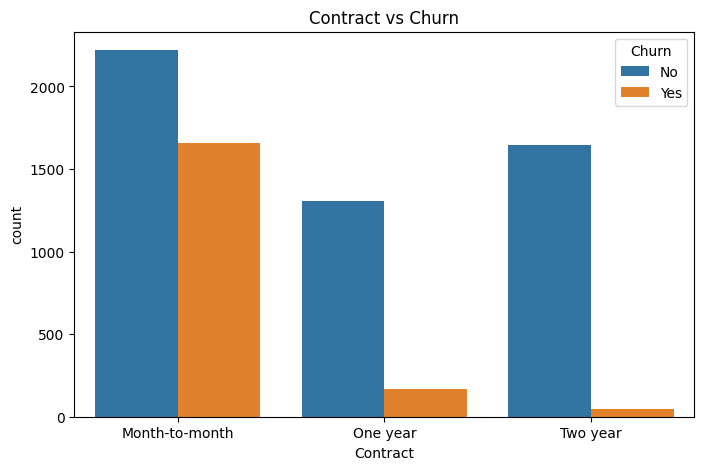

In [18]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x = 'Contract', hue = 'Churn',fill=True)
plt.title('Contract vs Churn')
plt.show()

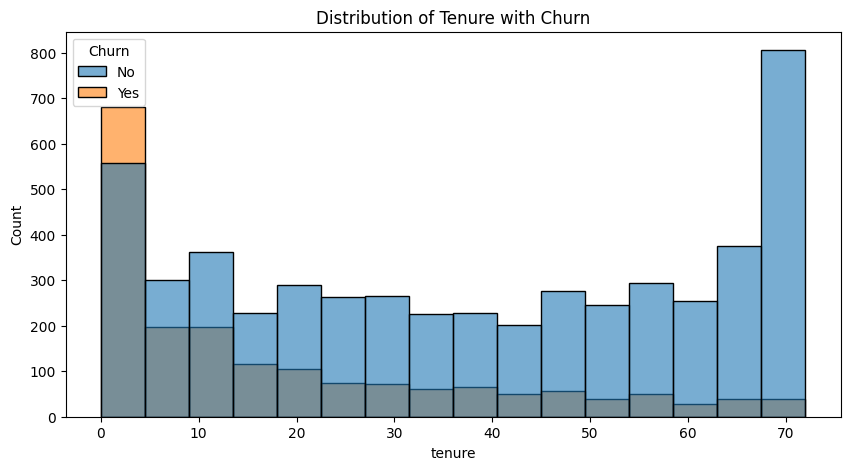

In [20]:
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='tenure', hue = 'Churn', fill = True, alpha = 0.6)
plt.title('Distribution of Tenure with Churn')
plt.show()

Correlation heatmap for numerical features

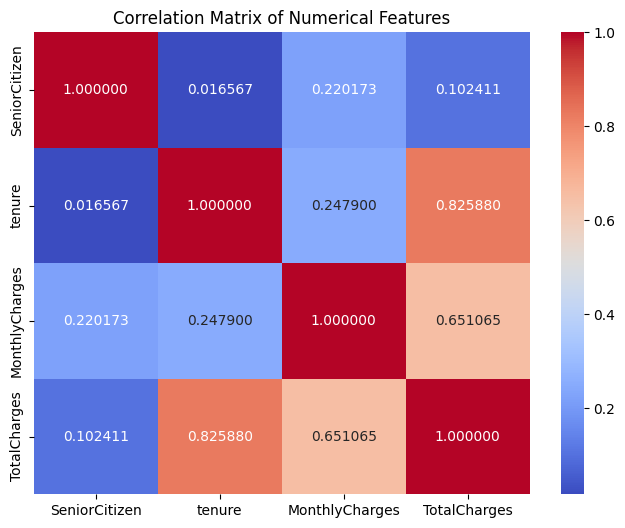

In [21]:
num_col = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(8,6))
sns.heatmap(df[num_col].corr(), annot = True, fmt='2f', cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

EDA Findings:

**Monthly Charges vs Churn:**  
  Customers with higher monthly charges are more likely to churn. Non-churned customers are concentrated at lower charge values.  

**Contract Type vs Churn:**  
  Churn is significantly higher for customers with **month-to-month contracts**, whereas customers on **one-year or two-year contracts** are much less likely to churn.  

**Tenure vs Churn:**  
  Customers with shorter tenure (new customers) show higher churn rates. Long-tenured customers are more loyal and less likely to churn.  

**Correlation Analysis:**  
  - Tenure and TotalCharges show a strong positive correlation (as expected).  
  - MonthlyCharges moderately correlates with TotalCharges.  
  - SeniorCitizen has little correlation with other numerical features.  

**Overall Insight:**  
Churn is strongly associated with **higher monthly charges, short tenure, and month-to-month contracts**. Longer contracts and customer loyalty (longer tenure) reduce the likelihood of churn.


Task 2: Feature Engineering

Feature 1: AvgMonthlyCharge
AvgMonthlyCharge = TotalCharges / Tenure

It gives an indication of per-month spending while avoiding division by zero.

It captures a customer’s *average monthly spend* over their lifetime.  
Highlights customers with unusually high spending relative to tenure, which may increase churn risk.  
Complements existing features (MonthlyCharges, Tenure) by showing long-term spending behaviour. 

In [24]:
df['AvgMonthlyCharge'] = df['TotalCharges']/df['tenure'].replace(0,1)

Feature 2: Count of the Services

This feature aggregates multiple service columns into one measure of engagement.  
Customers with more services are typically more loyal due to higher switching costs.  
Simplifies dimensionality while still capturing service depth.  

In [26]:
Services = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'InternetService']
df['ServicesCount'] = df[Services].apply( lambda row: sum(row=='Yes'), axis=1)

In [28]:
df[['AvgMonthlyCharge','ServicesCount']].head()

,AvgMonthlyCharge,ServicesCount
0,29.850000,1
1,55.573529,3
2,54.075000,3
3,40.905556,3
4,75.825000,1


Task 3: Building the End-to-End Pipeline

To ensure reproducibility and clean separation of preprocessing and modeling, we built a **Scikit-learn Pipeline**

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

In [58]:
numerical = ['tenure','MonthlyCharges', 'TotalCharges', 'AvgMonthlyCharge', 'ServicesCount']
categorical = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Contract', 'PaperlessBilling', 'PaymentMethod']

In [59]:
X = df[numerical+categorical]
y = df['Churn'].map({'No' : 0, 'Yes': 1})

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
numerical_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'median')), ('scaler', StandardScaler())])
categorical_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')), ('ohe', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([('num', numerical_pipeline, numerical), ('cat', categorical_pipeline, categorical)])

In [62]:
pipeline_lr = Pipeline([('preprocessor',preprocessor), ('classifier', LogisticRegression(max_iter=1000))])

The **ColumnTransformer** preprocessor is combined with a classifier (LogisticRegression) inside a single Pipeline.  
This way, raw input data passes through all preprocessing steps automatically before reaching the model.  

In [63]:
pipeline_lr.fit(X_train,y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [64]:
y_pred = pipeline_lr.predict(X_test)

In [65]:
from sklearn.metrics import classification_report, confusion_matrix
print('Classification report: \n')
print(classification_report(y_test, y_pred))

print('Confusion Matrix: \n')
print(confusion_matrix(y_test, y_pred))


Classification report: 

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.69      0.55      0.62       373

    accuracy                           0.82      1409
   macro avg       0.77      0.73      0.75      1409
weighted avg       0.81      0.82      0.81      1409

Confusion Matrix: 

[[943  93]
 [166 207]]


Classification Report 
**Class 1 (Churn customers):**  
Precision = 0.69 → When the model predicts "Churn," it is correct 69% of the time.  
Recall = 0.55 → The model only captures 55% of actual churners (many false negatives).  
F1-score = 0.62 → Performance on churn class is noticeably weaker than on non-churn.  

**Overall metrics:**  
Accuracy = **82%** → The model classifies most customers correctly, but accuracy alone can be misleading due to class imbalance.  
Macro Avg F1 = 0.75 → Balanced performance across both classes.  
Weighted Avg F1 = 0.81 → Reflects stronger performance on the majority class (non-churn).  

**Confusion Matrix**  
True Negatives (943): Correctly predicted non-churn.  
False Positives (93): Predicted churn but customer did not churn.  
False Negatives (166): Predicted non-churn but customer actually churned (critical misses).  
True Positives (207): Correctly predicted churn.  

**Key Insight:**  
The model performs well at identifying non-churners but struggles with detecting churners (low recall = 55%). Since the business goal is often to **retain customers at risk of leaving**, improving recall on churners is important. Possible strategies include:  
- Using techniques to handle class imbalance (SMOTE).  
- Trying more complex models (Random Forest, Gradient Boosting).  
- Hyperparameter tuning to improve recall.


Model Selection and Hyperparameter Tuning

From the metrices above we got to know that we need to improve the recall on churners, hence we select complex models like Random Forest, Gradient Boosting and do hyperparameter tuning.

The models represent a good balance of interpretability (Logistic Regression), robustness (Random Forest), and predictive power (Gradient Boosting).

In [66]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score

In [67]:
models = {
    'Logistic Regression' : LogisticRegression(max_iter=1000),
    'Random Forest' : RandomForestClassifier(random_state=42),
    'Gradient Boosting' : GradientBoostingClassifier(random_state=42)
}

As the dataset is imbalanced, we used **f1_weighted** as the primary scoring metric instead of accuracy, ensuring balanced evaluation across churn and non-churn classes.

In [68]:
for name, clf in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("classifier", clf)])
    scores = cross_val_score(pipe, X_train, y_train, 
                             cv=5, scoring="f1_weighted")
    print(f"{name}: mean f1_weighted = {scores.mean():.4f}")

Logistic Regression: mean f1_weighted = 0.7841
Random Forest: mean f1_weighted = 0.7721
Gradient Boosting: mean f1_weighted = 0.7805


We choose Logistic Regression as our best performing model as it has the highest f1 weighted score.

In [83]:
param_grid = {
    'classifier__C': [0.01,0.1,1,10,100],
    'classifier__penalty': ['l1','l2'],
    'classifier__solver': ['liblinear', 'saga']
}

In [84]:
gridsearch = GridSearchCV(
    estimator = pipeline_lr,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
)
gridsearch.fit(X_train, y_train)

/Users/subratotapaswi/Documents/ML/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/subratotapaswi/Documents/ML/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/subratotapaswi/Documents/ML/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/subratotapaswi/Documents/ML/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/subratotapaswi/Documents/ML/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

,estimator,Pipeline(step..._iter=1000))])
,param_grid,"{'classifier__C': [0.01, 0.1, ...], 'classifier__penalty': ['l1', 'l2'], 'classifier__solver': ['liblinear', 'saga']}"
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [87]:
print('Best Parameters:', gridsearch.best_params_)
print('Best f1 score:', gridsearch.best_score_)

y_pred = gridsearch.predict(X_test)
print('Test ROC AUC:', roc_auc_score(y_test,y_pred))
print('Test f1_weighted:', f1_score(y_test, y_pred, average='weighted'))
print('\nClassification Report:\n', classification_report(y_test, y_pred))


Best Parameters: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best f1 score: 0.7848675726372616
Test ROC AUC: 0.7325957228772243
Test f1_weighted: 0.8093402560383558

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.69      0.55      0.62       373

    accuracy                           0.82      1409
   macro avg       0.77      0.73      0.75      1409
weighted avg       0.81      0.82      0.81      1409



Task 5: Handling Class Imbalance 

The dataset was imbalanced, with significantly fewer churners (Class 1) compared to non-churners (Class 0). To address this, we applied **SMOTE (Synthetic Minority Oversampling Technique)** during training.

In [94]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [ ]:
smote = SMOTE(random_state =42)

In [97]:
imb_pipeline = ImbPipeline(steps = [('preprocessor', preprocessor),('smote', smote), ('classifier', LogisticRegression(max_iter = 1000, random_state=42))])
imb_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [102]:
y_pred_smote = imb_pipeline.predict(X_test)
print("Classification Report (with SMOTE):")
print(classification_report(y_test, y_pred_smote))

Classification Report (with SMOTE):
              precision    recall  f1-score   support

           0       0.93      0.71      0.81      1036
           1       0.52      0.86      0.65       373

    accuracy                           0.75      1409
   macro avg       0.73      0.78      0.73      1409
weighted avg       0.82      0.75      0.77      1409



**Before SMOTE (Best Logistic Regression):**  
- Recall (Churn = 1): **0.55**  
- Precision (Churn = 1): **0.69**  
- F1-score (Churn = 1): **0.62**  
- Weighted F1: **0.81**  

**After SMOTE:**  
- Recall (Churn = 1): **0.86** (significant improvement)  
- Precision (Churn = 1): **0.52** (dropped due to more false positives)  
- F1-score (Churn = 1): **0.65**  
- Weighted F1: **0.77**  

**Conclusion:**  
SMOTE greatly improved the model’s ability to **detect churners** (high recall), which is critical in churn prediction since missing churners (false negatives) is more costly than incorrectly flagging non-churners (false positives). However, this came at the expense of precision and overall accuracy.

Task 6

In [103]:
print("Test ROC AUC:", roc_auc_score(y_test, y_pred_smote))
print("Test f1_weighted:", f1_score(y_test, y_pred_smote, average="weighted"))

Test ROC AUC: 0.7847567981616239
Test f1_weighted: 0.7655942483796334


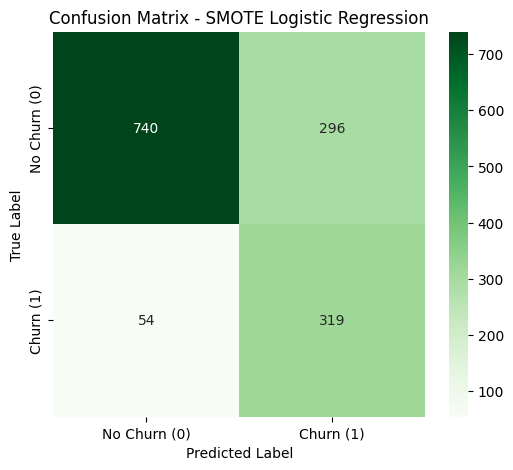

In [109]:
cm = confusion_matrix(y_test, y_pred_smote)
labels = ['No Churn (0)', 'Churn (1)']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - SMOTE Logistic Regression')
plt.show()

**Final Metrics (Test Set with SMOTE):**  
- ROC AUC: **0.785**  
- Weighted F1: **0.766**  
- Classification Report and Confusion Matrix confirm better recall for churners compared to the baseline.  

**Confusion Matrix Interpretation:**  
- **False Negatives (Churn predicted as No Churn = 54):** Risky for the business, as these customers might leave without any retention effort.  
- **False Positives (No Churn predicted as Churn = 296):** Less harmful; retention efforts may be wasted on loyal customers but are usually less costly than losing a churner.  

**Business Insight:**  
- In customer churn, **False Negatives are worse than False Positives**. It is better to incorrectly flag a loyal customer than to miss a churner who might actually leave.  
- By applying SMOTE, we prioritized **higher recall** to minimize false negatives, aligning the model with the business goal of retaining as many at-risk customers as possible.